In [20]:
# Import Libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
customers = pd.read_csv('Customers.csv')
products = pd.read_csv('Products.csv')
transactions = pd.read_csv('Transactions.csv')


In [44]:
# Merge transactions with customers and products
merged_data = transactions.merge(customers, on='CustomerID').merge(products, on='ProductID')


In [9]:
merged_columns = merged_data.columns



In [23]:
merged_data = transactions.merge(products, on='ProductID').merge(customers, on='CustomerID')


In [45]:
# Aggregate transaction data by CustomerID
customer_summary = merged_data.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'TransactionID': 'count',
}).rename(columns={'TransactionID': 'NumTransactions'})

# Calculate average transaction value
customer_summary['AvgTransactionValue'] = customer_summary['TotalValue'] / customer_summary['NumTransactions']


In [59]:
transactions_with_clusters = transactions.merge(customer_summary.reset_index()[['CustomerID', 'Cluster']], on='CustomerID', how='inner')

In [60]:
average_transaction_value_per_cluster = transactions_with_clusters.groupby('Cluster')['TotalValue'].mean().reset_index()
average_transaction_value_per_cluster.columns = ['Cluster', 'AverageTransactionValue']

print("Average Transaction Value per Cluster:")
print(average_transaction_value_per_cluster)

Average Transaction Value per Cluster:
   Cluster  AverageTransactionValue
0        0               734.517317
1        1               459.001818
2        2              1042.066379
3        3               708.906416


In [62]:
number_of_transactions_per_cluster = transactions_with_clusters.groupby('Cluster')['TransactionID'].count().reset_index()
number_of_transactions_per_cluster.columns = ['Cluster', 'NumberOfTransactions']

print("\nNumber of Transactions per Cluster:")
print(number_of_transactions_per_cluster)


Number of Transactions per Cluster:
   Cluster  NumberOfTransactions
0        0                   436
1        1                   275
2        2                   116
3        3                   173


In [63]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_summary[['TotalValue', 'NumTransactions', 'AvgTransactionValue']])


In [64]:
print(customer_summary.columns)

# Check the columns of transactions_with_clusters
print(transactions_with_clusters.columns)

Index(['TotalValue', 'NumTransactions', 'AvgTransactionValue', 'Cluster'], dtype='object')
Index(['TransactionID', 'CustomerID', 'ProductID', 'TransactionDate',
       'Quantity', 'TotalValue', 'Price', 'Cluster'],
      dtype='object')


In [65]:
from sklearn.cluster import KMeans

# Determine optimal number of clusters using the elbow method
inertia = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)


In [66]:
optimal_k = 4  # Example based on elbow method
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_summary['Cluster'] = kmeans.fit_predict(scaled_features)


In [67]:
from sklearn.metrics import davies_bouldin_score

db_index = davies_bouldin_score(scaled_features, customer_summary['Cluster'])
print(f'Davies-Bouldin Index: {db_index}')


Davies-Bouldin Index: 1.0604240399923033


In [68]:
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(scaled_features, customer_summary['Cluster'])
print(f'Silhouette Score: {silhouette_avg}')


Silhouette Score: 0.3135106549790539


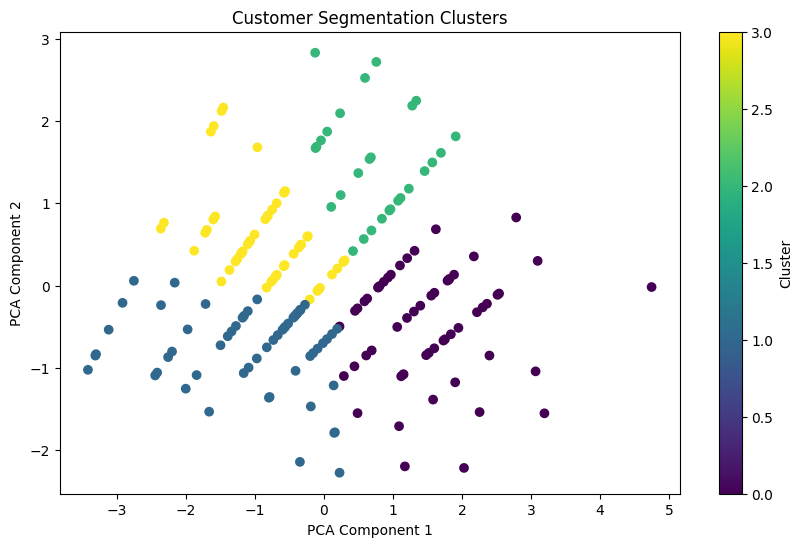

In [69]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced_features = pca.fit_transform(scaled_features)

plt.figure(figsize=(10, 6))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=customer_summary['Cluster'], cmap='viridis')
plt.title('Customer Segmentation Clusters')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()
